In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import pathlib
import pickle

import motorlab as ml
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import yaml

In [ ]:
DATA_DIR = pathlib.Path("data/")
EXPERIMENT = "old_gbyk"
SESSIONS = ml.sessions.get(EXPERIMENT)

In [ ]:
os.chdir(pathlib.Path().resolve().parent)

#### saving the orthogonal projection

**Notes**:
- This step should be executed only if one trains another model with a different uid.
- At the moment this only works for the old gbyk because we don't know the exact location for playground and the new gbyk has neural activity unsynced.

In [ ]:
run_id = "20250819231449"
model_path = (
    pathlib.Path("artifacts/poses_to_location/") / run_id / "best_model.pt"
)
model = torch.load(model_path)["model"]

for key in model:
    if "weight" in key:
        session = key.split(".")[1]
        meta_dir = DATA_DIR / EXPERIMENT / session / "poses" / "meta"
        W = model[key].cpu().numpy()
        orth_proj = np.eye(W.shape[-1]) - W.T @ np.linalg.inv(W @ W.T) @ W
        np.save(
            meta_dir / "orthogonal_projection.npy", orth_proj.astype(np.float32)
        )

### compare plots between egocentric vs egocentric + residualized

In [ ]:
poses_data = ml.data.load(
    session_dir=DATA_DIR / EXPERIMENT / SESSIONS[0],
    modalities=["poses"],
    query={},
    sampling_rate=20,
)

In [ ]:
egocentric_poses = ml.data.preprocess(
    poses_data,
    cfgs={"poses": {"coordinates": "egocentric", "residualize": False}},
    session_dir=DATA_DIR / EXPERIMENT / SESSIONS[0],
)

ml.plots.poses3d(egocentric_poses["poses"][0][100], experiment=EXPERIMENT)

In [ ]:
res_poses = ml.data.preprocess(
    poses_data,
    cfgs={"poses": {"coordinates": "egocentric", "residualize": True}},
    session_dir=DATA_DIR / EXPERIMENT / SESSIONS[0],
)

ml.plots.poses3d(res_poses["poses"][0][100], experiment=EXPERIMENT)

In [ ]:
print(
    all(
        not np.allclose(res_poses["poses"][i], egocentric_poses["poses"][i])
        for i in range(len(res_poses["poses"]))
    )
)

### model comparison

In [ ]:
runs = {
    "allocentric": 20250820181501,
    "centered": 20250820220905,
    "egocentric": 20250820232743,
    "adversarial": 20250822062312,
    "residualized": 20250821010031,
    "strict": 20250821094749,
    "draconian": 20250821094805,
}

In [ ]:
results = {
    "local correlation": [],
    "interval correlation": [],
    "global correlation": [],
    "representation": [],
    "interval type": [],
    "monkey": [],
    "area": [],
}

for representation, run in runs.items():
    cfg_path = pathlib.Path(f"artifacts/poses_to_spike_count/{run}/config.yml")
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    predictions_path = pathlib.Path(
        f"artifacts/poses_to_spike_count/{run}/predictions.pkl"
    )
    with open(predictions_path, "rb") as f:
        predictions = pickle.load(f)

    for session in cfg["sessions"]:
        session_dir = (
            pathlib.Path(cfg["data"]["dir"]) / cfg["experiment"] / session
        )
        areas = ml.spikes.get_areas_array(session_dir)
        intervals = ml.intervals.load_as_df(
            session_dir,
            sampling_rate=cfg["data"]["sampling_rate"],
        )
        gts = predictions["gts"][session]["spike_count"]
        gts_stacked = np.concatenate(gts, axis=0)
        preds = predictions["preds"][session]["spike_count"]
        preds_stacked = np.concatenate(preds, axis=0)

        results["global correlation"].extend(
            ml.metrics.global_correlation(
                gts_stacked, preds_stacked, reduce=False
            ).tolist()
        )
        results["area"].extend(areas.tolist())
        results["representation"].extend(
            [cfg["data"]["modalities"]["poses"]["representation"]] * len(areas)
        )
        results["interval type"].extend(
            [intervals.iloc[0]["type"]] * len(areas)
        )
        results["monkey"].extend([session.split("_")[0]] * len(areas))
        interval_corrs = np.array(
            [
                ml.metrics.global_correlation(gt, pred, reduce=False)
                for gt, pred in zip(gts, preds)
            ]
        )
        results["interval correlation"].extend(interval_corrs.mean(axis=0))
        local_corrs = np.array(
            [
                ml.metrics.local_correlation(gt, pred, reduce=False)
                for gt, pred in zip(gts, preds)
            ]
        )
        results["local correlation"].extend(local_corrs.mean(axis=0))

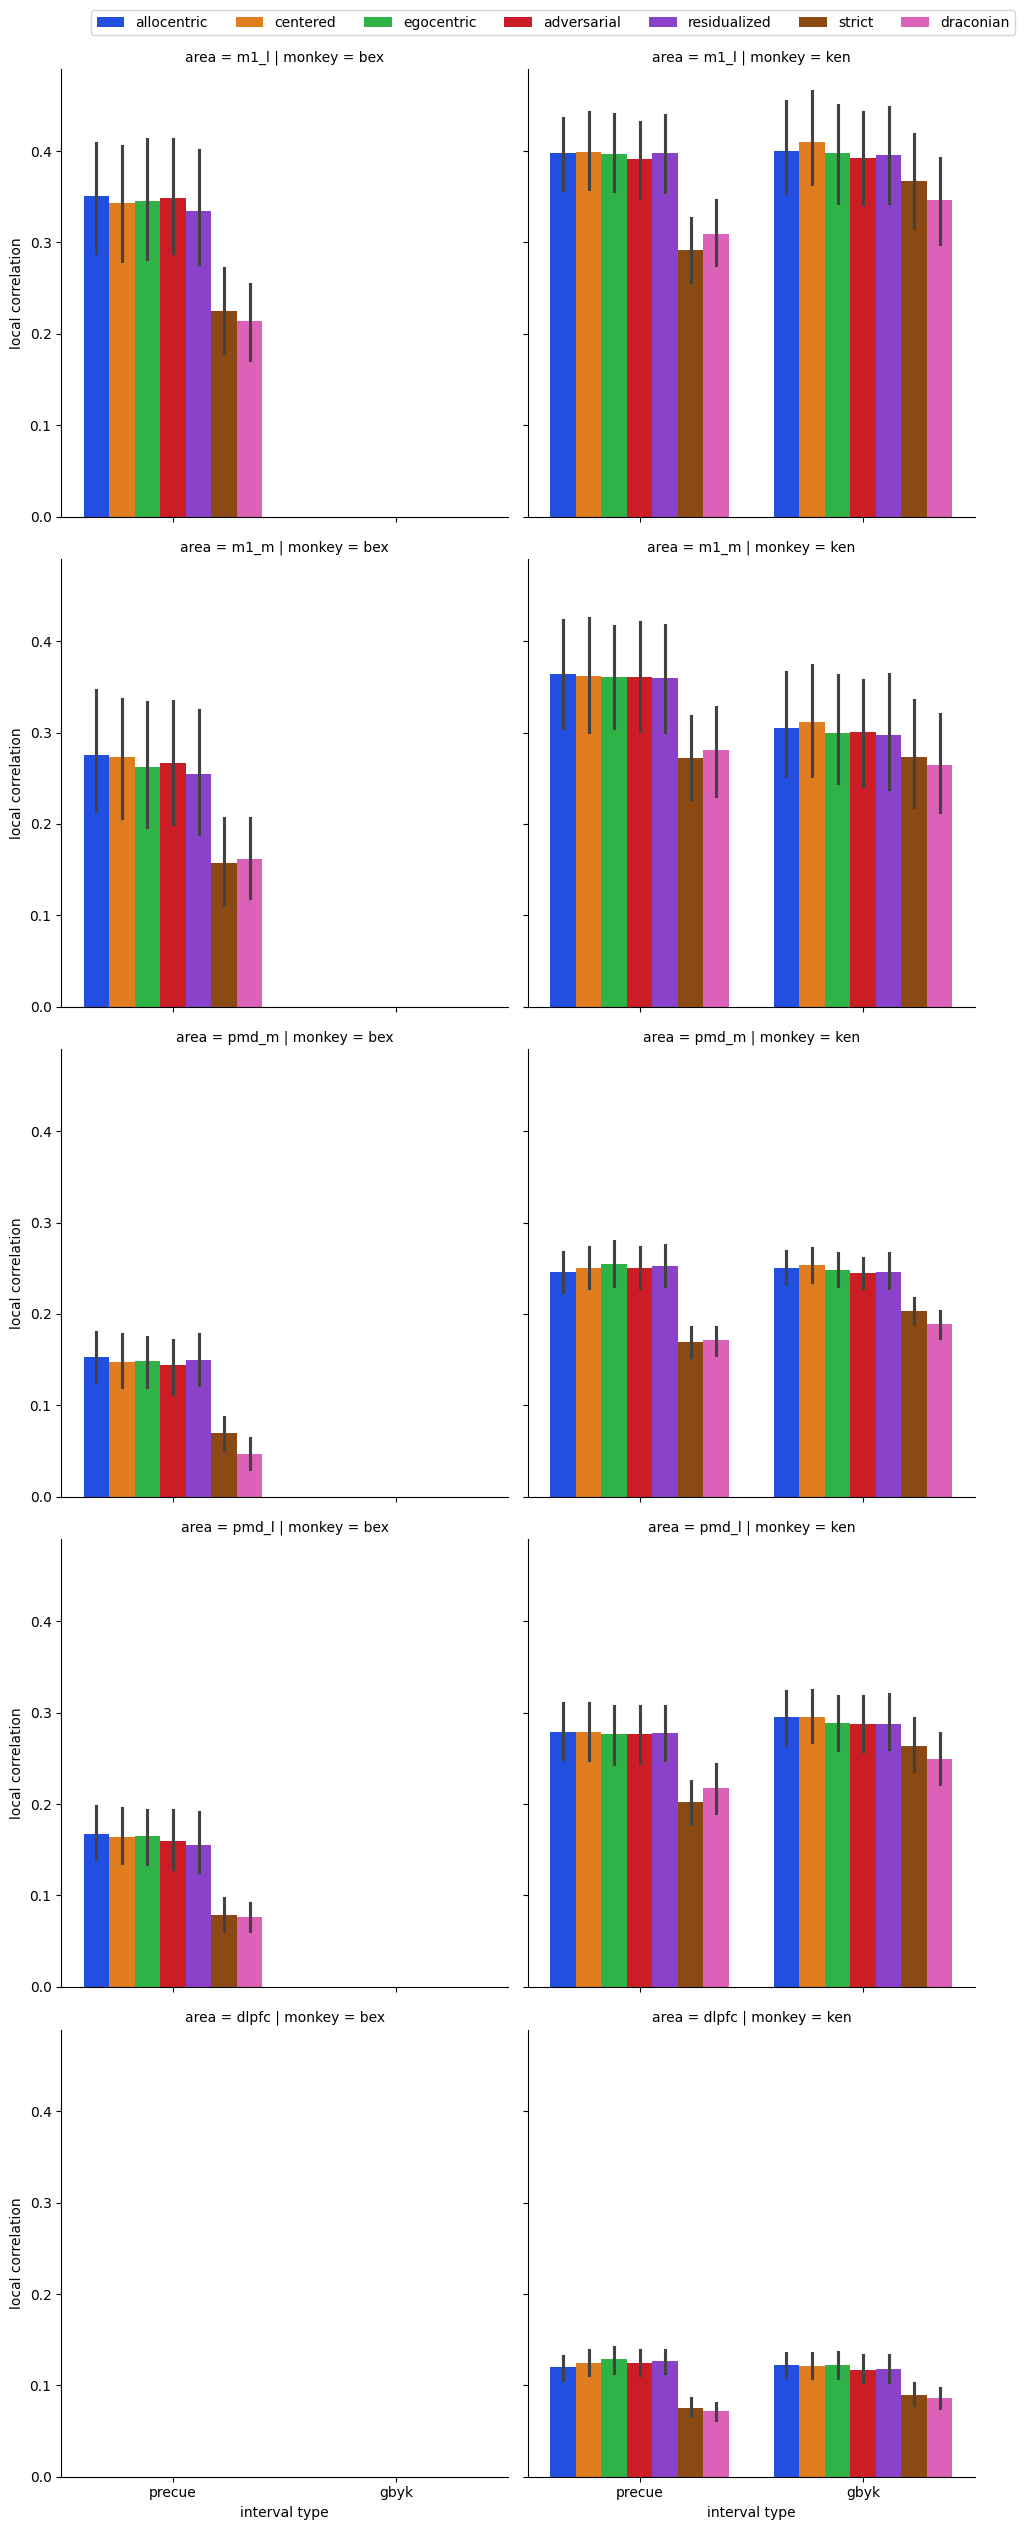

In [99]:
g = sns.catplot(
    data=results,
    x="interval type",
    y="local correlation",
    hue="representation",
    col="monkey",
    row="area",
    kind="bar",
    palette="bright",
)

legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.005),
    loc="center",
    ncol=len(runs),
    title="",
)

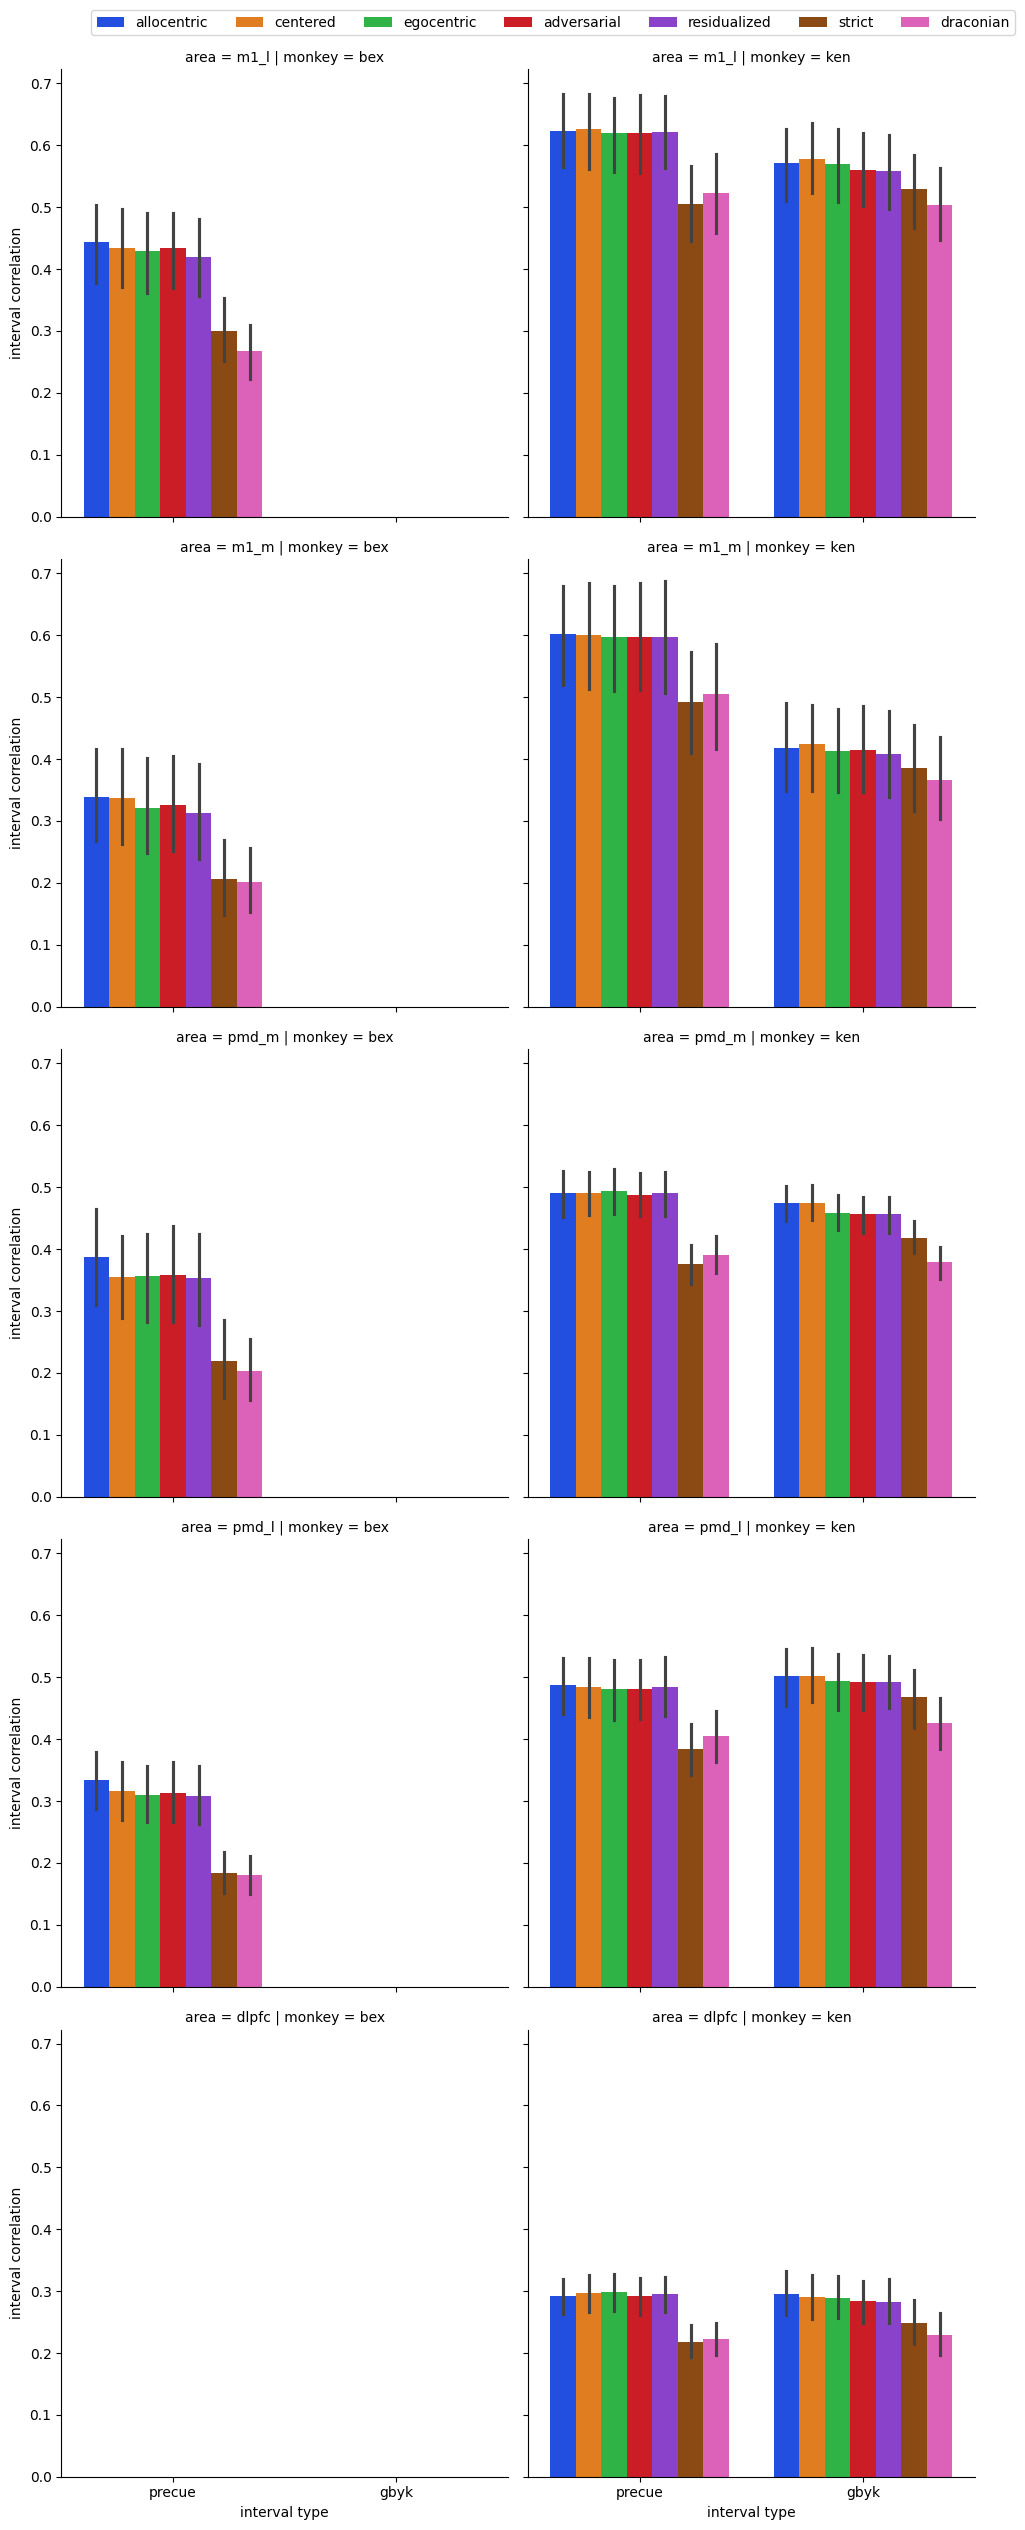

In [100]:
g = sns.catplot(
    data=results,
    x="interval type",
    y="interval correlation",
    hue="representation",
    col="monkey",
    row="area",
    kind="bar",
    palette="bright",
)

legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.005),
    loc="center",
    ncol=len(runs),
    title="",
)

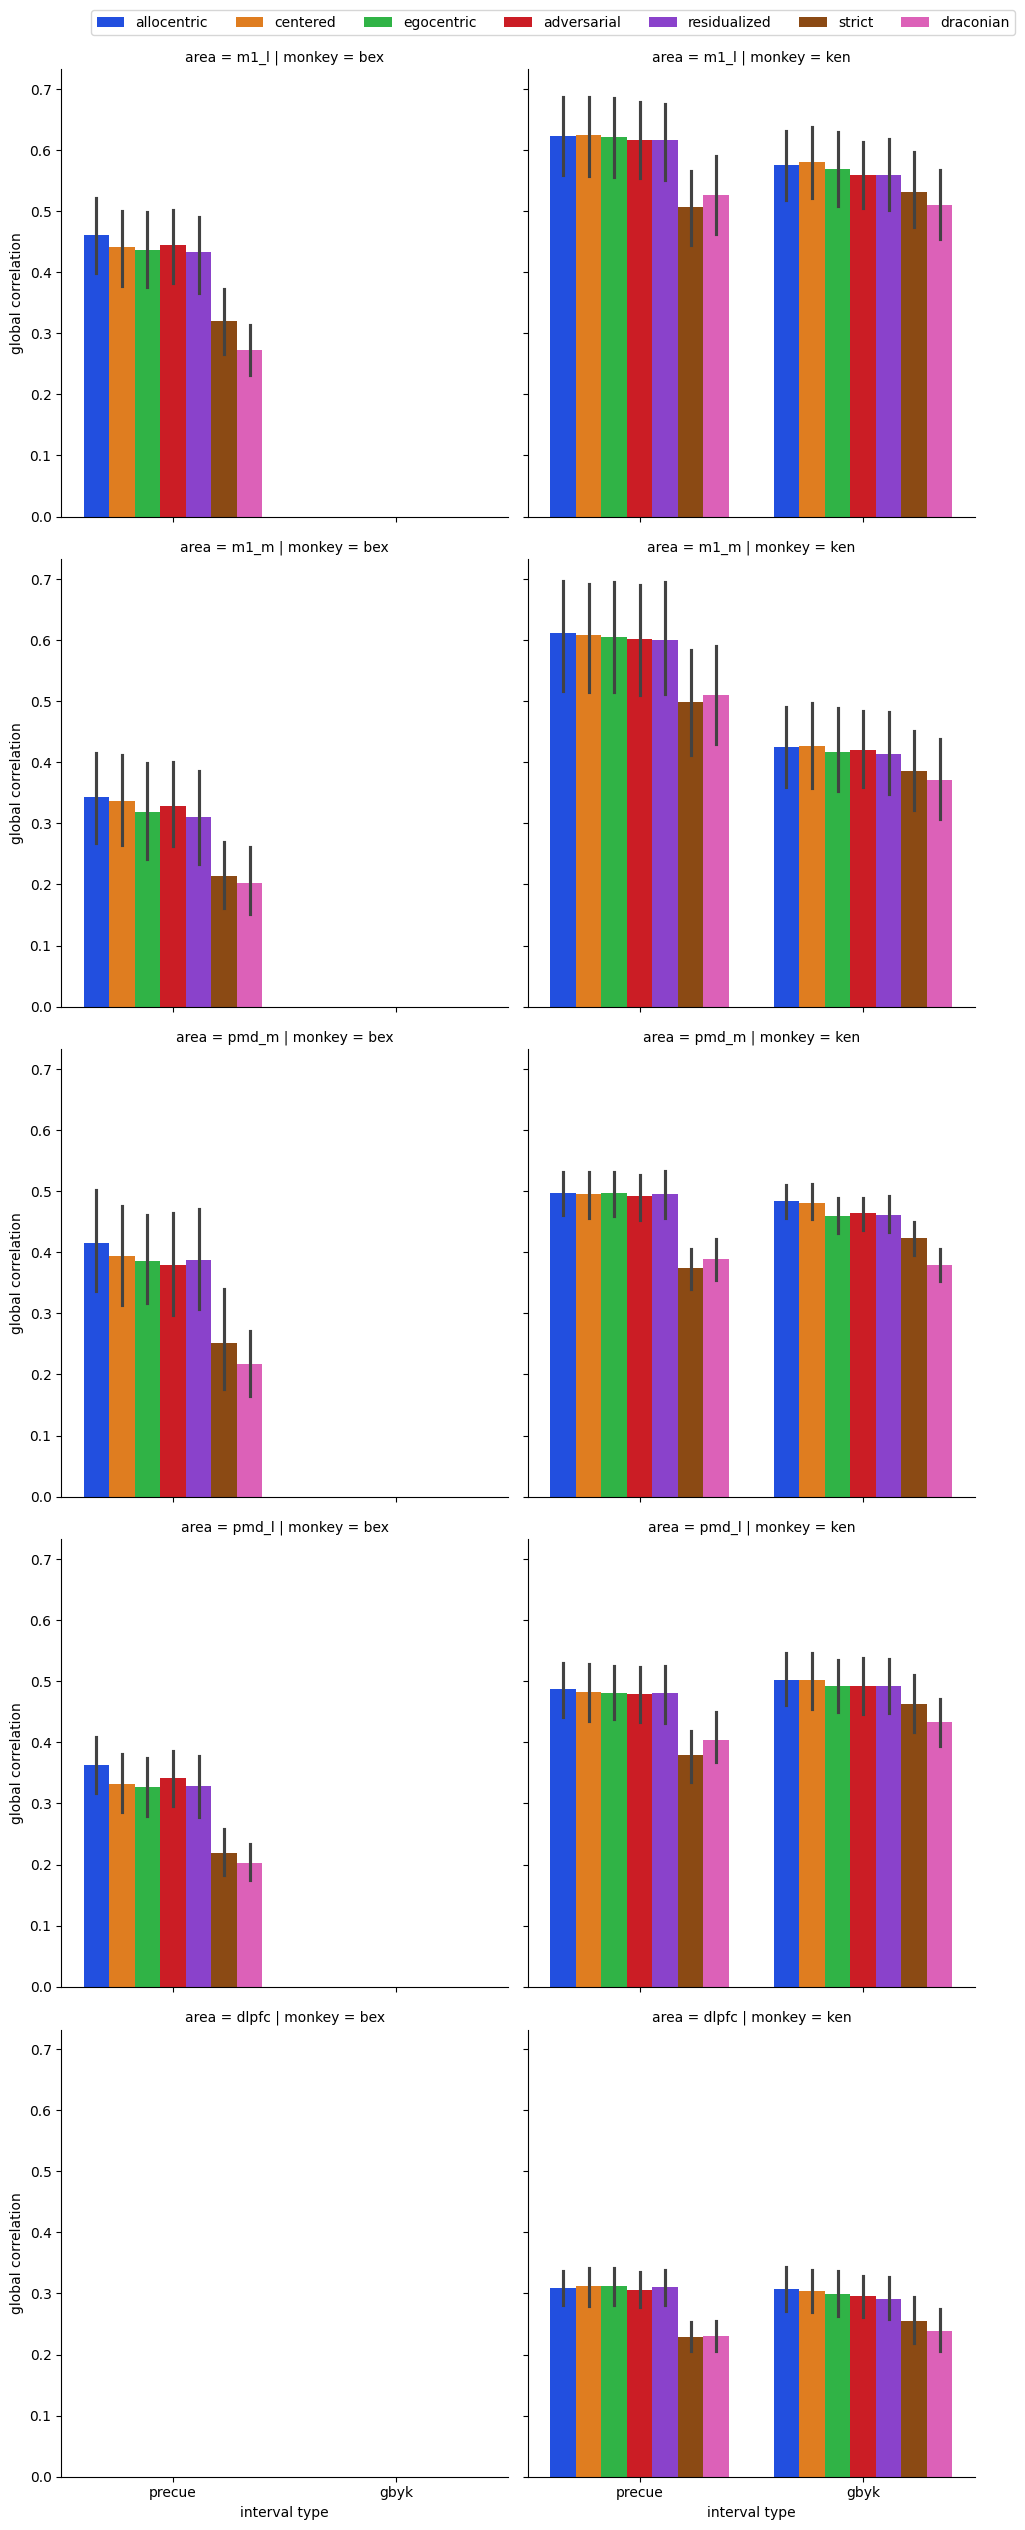

In [101]:
g = sns.catplot(
    data=results,
    x="interval type",
    y="global correlation",
    hue="representation",
    col="monkey",
    row="area",
    kind="bar",
    palette="bright",
)

legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.005),
    loc="center",
    ncol=len(runs),
    title="",
)